In [4]:

!pip install pytest-timeit

You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pykitti

# Change this to the directory where you store KITTI data
basedir = 'R:/'

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)
    #print(dataset)
    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset


In [3]:
from timeit import default_timer as timer 
#2011_09_26
date = '2011_09_26'
drive = '0048'
start = timer()
print("start:",start)
dataset = load_dataset(date, drive)
val1= timer()-start
print("val1: ",val1)
#print(dataset)
#tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), '/home/mcw/Documents/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))
#print(tracklet_types)

start: 4.4720358

Drive: 2011_09_26_drive_0048_sync

Frame range: None
val1:  0.015222500000000139


Ransac to fit the plane:  0.08311489999999822
Using DBSCAN function:  2.2160313999999914
update the values as zero for noise cluster to avoid ploting unwanted point clouds:  0.004441999999983182
separate the cluster points:  0.026451600000001463
Time taken to plot the obstacles:  0.02774430000002326
plot the bbox:  0.4672075999999947
___------Entire Time taken for each Frame------___ 2.848848199999992


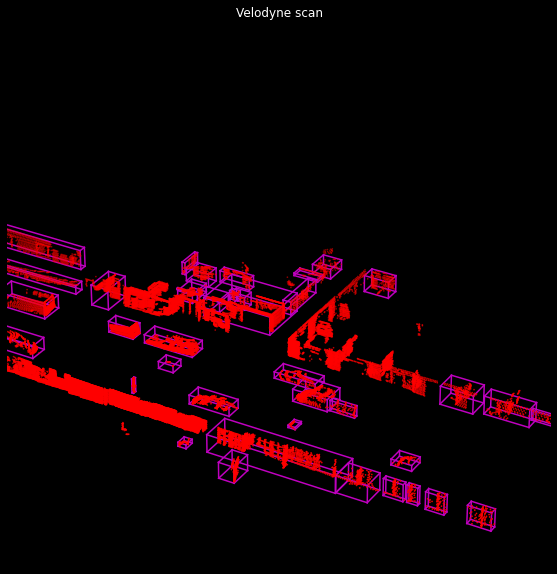

In [9]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
from sklearn.cluster import DBSCAN
#from cuml.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import Counter
import imageio
import cv2
import vispy.scene
from vispy.scene import visuals
from vispy import app, scene
import sys
from timeit import default_timer as timer

axes_limits = [
    [-20,80], # X axis range
    [-10,30], # Y axis range
    [-3, 5]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']
class plot3d(object):
    def __init__(self):
        self.app = pg.mkQApp()
        self.view = gl.GLViewWidget()
        coord = gl.GLAxisItem()
        glLineWidth(3)
        coord.setSize(3,3,3)
        self.view.addItem(coord)
    def add_points(self, points, colors):
        points_item = gl.GLScatterPlotItem(pos=points, size=2, color=colors)
        self.view.addItem(points_item)
    def add_line(self, p1, p2):
        lines = np.array([[p1[0], p1[1], p1[2]],
                          [p2[0], p2[1], p2[2]]])
        lines_item = gl.GLLinePlotItem(pos=lines, mode='lines',
                                       color=(1,0,0,1), width=3, antialias=True)
        self.view.addItem(lines_item)
    def show(self):
        self.view.show()
        self.app.exec()
        
'''CAM = 2
def load_calib(calib_dir):
    # P2 * R0_rect * Tr_velo_to_cam * y
    lines = open(calib_dir).readlines()
    lines = [ line.split()[1:] for line in lines ][:-1]
    #
    P = np.array(lines[CAM]).reshape(3,4)
    #
    Tr_velo_to_cam = np.array(lines[5]).reshape(3,4)
    Tr_velo_to_cam = np.concatenate(  [ Tr_velo_to_cam, np.array([0,0,0,1]).reshape(1,4)  ], 0 )
    #
    R_cam_to_rect = np.eye(4)
    R_cam_to_rect[:3,:3] = np.array(lines[4][:9]).reshape(3,3)
    #
    P = P.astype('float32')
    Tr_velo_to_cam = Tr_velo_to_cam.astype('float32')
    R_cam_to_rect = R_cam_to_rect.astype('float32')
    return P, Tr_velo_to_cam, R_cam_to_rect
def prepare_velo_points(pts3d_raw):
    Replaces the reflectance value by 1, and tranposes the array, so
        points can be directly multiplied by the camera projection matrix
    pts3d = pts3d_raw
    # Reflectance > 0
    indices = pts3d[:, 3] > 0
    pts3d = pts3d[indices ,:]
    pts3d[:,3] = 1
    return pts3d.transpose(), indices
def project_velo_points_in_img(pts3d, T_cam_velo, Rrect, Prect):
    Project 3D points into 2D image. Expects pts3d as a 4xN
        numpy array. Returns the 2D projection of the points that
        are in front of the camera only an the corresponding 3D points.
    # 3D points in camera reference frame.
    pts3d_cam = Rrect.dot(T_cam_velo.dot(pts3d))
    # Before projecting, keep only points with z>0
    # (points that are in fronto of the camera).
    idx = (pts3d_cam[2,:]>=0)
    pts2d_cam = Prect.dot(pts3d_cam[:,idx])
    return pts3d[:, idx], pts2d_cam/pts2d_cam[2,:], idx '''
def voxel_filter(point_cloud, leaf_size, random=False):
    
    filtered_points = []
         # Calculate boundary points
    x_min, y_min, z_min = np.amin(point_cloud, axis=0) #Calculate the maximum value of the three dimensions of x y z
    x_max, y_max, z_max = np.amax(point_cloud, axis=0)
 
         # Calculate voxel grid dimension
    Dx = (x_max - x_min)//leaf_size + 1
    Dy = (y_max - y_min)//leaf_size + 1
    Dz = (z_max - z_min)//leaf_size + 1
    #print("Dx x Dy x Dz is {} x {} x {}".format(Dx, Dy, Dz))
 
    # Calculate the voxel index of each point
    h = list() #h is the list to save the index
    for i in range(len(point_cloud)):
        hx = (point_cloud[i][0] - x_min)//leaf_size
        hy = (point_cloud[i][1] - y_min)//leaf_size
        hz = (point_cloud[i][2] - z_min)//leaf_size
        h.append(hx + hy*Dx + hz*Dx*Dy)
    h = np.array(h)
 
         # Screening points
    h_indice = np.argsort(h) # Returns the index of the elements in h sorted from small to large
    h_sorted = h[h_indice]
    begin = 0
    for i in range(len(h_sorted)-1):   # 0~9999
        if h_sorted[i] == h_sorted[i + 1]:
            continue
        else:
            point_idx = h_indice[begin: i + 1]
            filtered_points.append(np.mean(point_cloud[point_idx], axis=0))
            begin = i
 
         # Change the point cloud format to array and return to the outside
    filtered_points = np.array(filtered_points, dtype=np.float64)
    
    return filtered_points
    
def draw_point_cloud2(data1,ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    axes_limits = [
             [-10, 30], # X axis range
             [-10,20], # Y axis range
             [-3, 20]   # Z axis range
      
    ]
    axes_str = ['X', 'Y', 'Z']
    #ax.scatter(inliers.X , inliers.Y,  inliers.Z,  c="green",s=3)
    ax.scatter(data1[:,0],data1[:,1],data1[:,2], c="r",s=0.5)
    ax.set_title(title)
    #ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    #ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        #ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)
        #for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            #draw_box(ax, t_rects, axes=axes, color=colors[t_type])
def local_regression_plane_ransac(neighborhood):
    """
    Computes parameters for a local regression plane using RANSAC
    """
    ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.45,max_trials=100)
    ransac.fit(neighborhood[:,:2], neighborhood[:,2])
    
    #print(data.shape)
    inliers = ransac.inlier_mask_
    return neighborhood[inliers== False]
    #print(inliers)
    #print(inliers.shape)
    #outliers = inliers == False
    #print(inliers.shape,inliers.size)
    #series = pd.Series(inliers)
    #print(series)
    #val=neighborhood[series== False]
    
    #print(val)
    
   
    #print(val)
    #print(val.shape,val.size)
    
    '''axes=[0, 1, 2]
    axes_limits = [
        [-10, 40], # X axis range
        [-10,20], # Y axis range
        [-3, 9]   # Z axis range
        ]
    
    axes=[0, 1, 2]
    f2 = plt.figure(figsize=(10, 10))
    ax = f2.add_subplot(111, projection='3d')
    #ax.view_init(270,1)
    ax.plot(neighborhood[inliers, 0], neighborhood[inliers, 1],neighborhood[inliers, 2], '.g', alpha=0.6)
    #ax.plot(neighborhood[outliers, 0], neighborhood[outliers, 1],neighborhood[outliers, 2], '.r', alpha=0.3)
    #ax.plot(x1, yy, '-g', label='Robust line model')
    ax.set_xlim3d(*axes_limits[axes[0]])
    ax.set_ylim3d(*axes_limits[axes[1]])
    ax.set_zlim3d(*axes_limits[axes[2]])
    ax.set_xlim3d((-3,20))
    plt.style.use('dark_background')
    plt.axis("off")'''
    
    return neighborhood[inliers== False]
def create_bbox_mesh(p3d, gt_boxes3d):
    b = gt_boxes3d
    for k in range(0,4):
        i,j=k,(k+1)%4
        p3d.add_line([b[i,0],b[i,1],b[i,2]], [b[j,0],b[j,1],b[j,2]])
        i,j=k+4,(k+1)%4 + 4
        p3d.add_line([b[i,0],b[i,1],b[i,2]], [b[j,0],b[j,1],b[j,2]])
        i,j=k,k+4
        p3d.add_line([b[i,0],b[i,1],b[i,2]], [b[j,0],b[j,1],b[j,2]])
    
def draw_box(ax, vertices, axes=[0, 1, 2], color='black'):
    vertices = vertices[axes, :]
    #print(vertices)
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        ax.plot(*vertices[:, connection], c=color, lw=1.5)
        
        
def display_frame_statistics(dataset, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    '''dataset_gray = list(dataset.gray)
    
    
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()
    #velo_frame = dataset_velo[frame] #[velo_range, :]      
    #print(velo_frame.shape)
    #(rows,cols)
    
    #calib_dir='R:/002000.txt'
    #start = timer()
    #print(calib_dir)
    #img = plt.imread(img_dir)
    #pts = load_velodyne_points( pc_dir )
    #P, Tr_velo_to_cam, R_cam_to_rect = load_calib(calib_dir)
   
    
    #pts3d, indices = prepare_velo_points(velo_frame)
    #pts3d_ori = pts3d.copy()
    #reflectances = velo_frame[indices, 3]
    #pts3d, pts2d_normed, idx = project_velo_points_in_img( pts3d, Tr_velo_to_cam, R_cam_to_rect, P  )
    #print reflectances.shape, idx.shape
    #reflectances = reflectances[idx]
    #print reflectances.shape, pts3d.shape, pts2d_normed.shape
    #assert reflectances.shape[0] == pts3d.shape[1] == pts2d_normed.shape[1]
    #rows, cols = img.shape[:2]
    #print(rows,cols)
    #img = plt.imread(dataset_gray[frame][0])
    #print(img.shape)
    #rows, cols = 375, 1242
    cols, rows = dataset_rgb[frame][0].size
    points = []
    for i in range(pts2d_normed.shape[1]):
        c = int(np.round(pts2d_normed[0,i]))
        r = int(np.round(pts2d_normed[1,i]))
        if c < cols and r < rows and r > 0 and c > 0:
            #color = img[r, c, :]
            point = [ pts3d[0,i], pts3d[1,i], pts3d[2,i]]
            points.append(point)
            
    val2= timer()-start
    print("Time taken to crop the file: ",val2)'''
    #image = list(dataset.gray)
    #fig, ax = plt.subplots(1, figsize=(5,10))
    #ax.imshow(image[frame][0], cmap='gray')
    start1=timer()
    
    #print(image)
    dataset_velo = list(dataset.velo)
   
    velo_frame = dataset_velo[frame]
    
    #dataset_rgb = list(dataset.rgb)
    #f, ax = plt.subplots(1, 1, figsize=(5, 5))
    #ax[0, 1].set_title('Right Gray Image (cam1)')
    #ax.imshow(dataset_rgb[frame][0])
    
    
    #bin_path=np.fromfile().reshape(-1,4)
    #velo_frame  = np.fromfile(str('/root/Documents/Kitti/testing/velodyne_orig/002076.bin'),dtype=np.float32).reshape([-1, 4])
    #points= np.fromfile(str('R:/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000000.bin'), dtype=np.float32).reshape([-1, 4])
    outlier_data = velo_frame[:,0:3]
    #print(outlier_data)
    '''f2 = plt.figure(figsize=(10, 10))
    ax = f2.add_subplot(111, projection='3d')
    draw_point_cloud2(outlier_data,ax, 'Velodyne scan',xlim3d=(-5,20))
    plt.style.use('dark_background')
    plt.axis("off")'''
    #return points
    start=timer()
    outliers=local_regression_plane_ransac(outlier_data)
    val3= timer()-start
    print("Ransac to fit the plane: ",val3)
    #print(outliers)
    
    #start=timer()
    #outliers = voxel_filter(outliers, 0.01, random=True)
    #valfil= timer()-start
    #print("filtered points: ",valfil)
    start=timer()
    db = DBSCAN(eps=0.60,min_samples=20).fit(outliers)
    val4= timer()-start
    print("Using DBSCAN function: ",val4)
    labels = db.labels_
    #print(labels)
    #print(labels)
    #print(len(labels))
    clusters = len(set(labels)) - (1 if -1 in labels else 0)
    #print("____No of clusters____:",clusters)
    #n_noise_ = list(labels).count(-1)
    #print(n_clusters_,n_noise_ )
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    
    '''f2 = plt.figure(figsize=(15, 15))
    ax = f2.add_subplot(111, projection='3d')  
    ax.view_init(270,1)
    #figure, axis = plt.subplots(2, 2)
    ##############################################################################
    # Plot result
    #import matplotlib.pyplot as plt
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    #print(len(unique_labels))
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = outliers[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=5)
        xy = outliers[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=3)
    #plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.axis("off")
    plt.show()'''
    start=timer()
    ii = np.where(labels== -1)[0]
    for i in ii:
        outliers[i]=[0,0,0]
    val5= timer()-start
    print("update the values as zero for noise cluster to avoid ploting unwanted point clouds: ",val5)
    #outliers_vox=[]
    #i=0
    #for point in outliers:
        #if labels[i] == -1:
        #outliers[i]=[0,0,0]
        #else:
         #   outliers_vox.append()
        #i=i+1
    #clusters1=Counter(db.labels_)
    #print(clusters1)
    start=timer()
    cl=[[] for i in range(clusters)]
    
    for i in range(len(labels)):
        cl[labels[i]].append(outliers[i])
        
    val10= timer()-start
    print("separate the cluster points: ",val10)
    #print(cl[8])
    '''
    start=timer()
    canvas = vispy.scene.SceneCanvas(keys='interactive',bgcolor='black', show=True)
    view = canvas.central_widget.add_view()

    #points  = np.fromfile(str('R:/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000000.bin'),dtype=np.float32).reshape([-1, 4])
    #example=example[:0:3]
    #print(points)
    # create scatter object and fill in the data
    scatter = visuals.Markers()
    scatter.set_data(outliers[:,:3], edge_color='r', face_color=(1, 1, 1, 0.5), size=0.5)
    view.add(scatter)
    view.camera = scene.TurntableCamera(up='z', fov=90)
    view.camera.distance = 30
    
    
    for i in cl:
        #print(clusters[i],end=" ")
        #searchval = i
        #points=outliers[pd.Series(labels)== i]
        points=np.asarray(i)
        #print(points)
        #print(val)
        #break
        #ii = np.where(labels== i)[0]
        if(len(i)>=50 and len(i)<=5000):
            points=np.asarray(i)
            #point=[outliers[j] for j in ii]
            #points=np.asarray(point)
            #print(points)
            x_max, x_min = np.max(points[:, 0]), np.min(points[:, 0])
            y_max, y_min = np.max(points[:, 1]), np.min(points[:, 1])
            z_max, z_min = np.max(points[:, 2]), np.min(points[:, 2])
            box1 = scene.visuals.Box(width=(x_max-x_min), height=(z_max-z_min), depth=(y_max-y_min), color=(0, 0, 1, 0.3))
            #print(box1)
            mesh_box1 = box1.mesh.mesh_data
            vertices = mesh_box1.get_vertices()
            center=np.array([(x_min),(y_min),(z_min)],dtype=np.float32)
            vtcs = np.add(vertices,center)
            mesh_box1.set_vertices(vtcs)
            mesh_border_box1 = box1.border.mesh_data
            view.add(box1)
            #break
            #box = np.zeros([8, 3])
    canvas.show()
    print("Time taken for plotting",timer()-start)
    
    

    # Make a canvas and add simple view
   
    
    # add a colored 3D axis for orientation
   # box1.transform = transforms.STTransform(translate=(0., 0., 0.),scale=(1., 1., 1.))
    #axis = visuals.XYZAxis(parent=view.scene)

    
    #view.camera = 'arcball'  # or try 'arcball'
    # add a colored 3D axis for orientation
    #axis = scene.visuals.XYZAxis(parent=view.scene)
    
    '''
    start=timer()
    
    f2 = plt.figure(figsize=(10, 10))
    ax = f2.add_subplot(111, projection='3d')
    
    draw_point_cloud2(outliers,ax, 'Velodyne scan',xlim3d=(-5,20))
    val6= timer()-start
    print("Time taken to plot the obstacles: ",val6)
    #ax.view_init(45,1)        
    plt.style.use('dark_background')
    plt.axis("off")
    
    
    #p3d = plot3d()
    #color=(0, 0, 255)
    #thickness=2
    start=timer()
    #box_coord_list =[]
    for i in cl:
        #print(clusters[i],end=" ")
        #searchval = i
        #points=outliers[pd.Series(labels)== i]
        points=np.asarray(i)
        #print(points)
        #print(val)
        #break
        #ii = np.where(labels== i)[0]
        if(len(i)>=50 and len(i)<=5000):
            points=np.asarray(i)
            #point=[outliers[j] for j in ii]
            #points=np.asarray(point)
            #print(points)
            x_max, x_min = np.max(points[:, 0]), np.min(points[:, 0])
            y_max, y_min = np.max(points[:, 1]), np.min(points[:, 1])
            z_max, z_min = np.max(points[:, 2]), np.min(points[:, 2])
            box = np.zeros([8, 3])
            box[0, :] =[x_min, y_min, z_min]
            box[1, :] =[x_max, y_min, z_min]
            box[2, :] =[x_max, y_max, z_min]
            box[3, :] =[x_min, y_max, z_min]
            box[4, :] =[x_min, y_min, z_max]
            box[5, :] =[x_max, y_min, z_max]
            box[6, :] =[x_max, y_max, z_max]
            box[7, :] =[x_min, y_max, z_max]
            box = np.transpose(box)
            #print(box[0],box[1],box[2])
            #break
            draw_box(ax, box, axes=[0, 1, 2], color='m') 
            #print(box)
            #create_bbox_mesh(p3d, box)
    val8= timer()-start
    print("plot the bbox: ",val8)
    val9= timer()-start1
    print("___------Entire Time taken for each Frame------___",val9)
    filename = 'R:/Outputs/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    return filename
frames = []
n_frames = len(list(dataset.velo))
#print('Preparing animation frames...')
for i in range(1):
    filename = display_frame_statistics(dataset,i)
    frames += [filename]
    


In [10]:
import os
import imageio
path = '/home/mcw/outputs_f/'
images = []

for i in frames:
    images.append(imageio.imread(i))
#print(images)

imageio.mimsave('animruth.gif', images,duration=1)

In [11]:
import os
import pandas as pd
import numpy as np
import flask
import cv2
from flask import Flask, render_template, request,Response
import time
app = Flask(__name__)
@app.route('/')
def index():
    # rendering webpage
    return render_template('index.html')
def gen():
    #hists = os.listdir('/home/sathish/Output/')
    #for hist in hists:
    frame = cv2.imread('R:/Outputs/frame_0000')
    frame=cv2.resize(frame,(640,640))
    cv2.imwrite("out.jpeg",frame)
    ret, frame = cv2.imencode('.jpg', frame)
    frame_bytes = frame.tobytes()
    #time.sleep(0.5)
    yield(b'--frame_bytes\r\n'
           b'Content-Type: image/jpeg\r\n\r\n' + frame_bytes + b'\r\n\r\n')
@app.route('/read_data')
def read_data():
    print("reading data")
    return Response(gen(),mimetype='multipart/x-mixed-replace; boundary=frame_bytes')
if __name__ == '__main__':
    # defining server ip address and port
    app.run(host='127.0.0.1',port='2222', debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:2222/ (Press CTRL+C to quit)
127.0.0.1 - - [26/May/2021 21:49:50] "GET / HTTP/1.1" 200 -


reading data


127.0.0.1 - - [26/May/2021 21:49:50] "GET /read_data HTTP/1.1" 500 -
127.0.0.1 - - [26/May/2021 21:49:50] "GET /favicon.ico HTTP/1.1" 404 -
Error on request:
Traceback (most recent call last):
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\serving.py", line 323, in run_wsgi
    execute(self.server.app)
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\serving.py", line 314, in execute
    for data in application_iter:
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\wsgi.py", line 506, in __next__
    return self._next()
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\wrappers\base_response.py", line 45, in _iter_encoded
    for item in iterable:
  File "<ipython-input-11-fc942cb92896>", line 17, in gen
    
cv2.error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\imgproc\src\resize.cpp:405

reading data


127.0.0.1 - - [26/May/2021 21:50:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/May/2021 21:50:16] "GET /read_data HTTP/1.1" 500 -
Error on request:
Traceback (most recent call last):
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\serving.py", line 323, in run_wsgi
    execute(self.server.app)
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\serving.py", line 314, in execute
    for data in application_iter:
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\wsgi.py", line 506, in __next__
    return self._next()
  File "c:\users\mcw\appdata\local\programs\python\python36\lib\site-packages\werkzeug\wrappers\base_response.py", line 45, in _iter_encoded
    for item in iterable:
  File "<ipython-input-11-fc942cb92896>", line 17, in gen
    
cv2.error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\imgproc\src\resize.cpp:4051: error: (

reading data


In [70]:
import MotionClouds as mc
from vispy import app, scene
from vispy.util.transforms import perspective, translate, rotate
from vispy import gloo

canvas = scene.SceneCanvas(keys='interactive', size =(1280, 1024), position = (0, 0), bgcolor='white', dpi=450)

view = canvas.central_widget.add_view()

#N_X, N_Y, N_frame= mc.N_X, mc.N_Y, mc.N_frame

N_X, N_Y, N_frame= 1,1,1

axis = scene.visuals.XYZAxis(parent=view.scene)
for p in ([1, 1, 1, -1, 1, 1], [1, 1, -1, -1, 1, -1], [1, -1, 1, -1, -1, 1],[1, -1, -1, -1, -1, -1], 
          [1, 1, 1, 1, -1, 1], [-1, 1, 1, -1, -1, 1], [1, 1, -1, 1, -1, -1], [-1, 1, -1, -1, -1, -1], 
          [1, 1, 1, 1, 1, -1], [-1, 1, 1, -1, 1, -1], [1, -1, 1, 1, -1, -1], [-1, -1, 1, -1, -1, -1]):
    line = scene.visuals.Line(pos=np.array([[p[0]*N_X/2, p[1]*N_Y/2, p[2]*N_frame/2], [p[3]*N_X/2, p[4]*N_Y/2, p[5]*N_frame/2]]), color='black', parent=view.scene)

#axisX = scene.visuals.Line(pos=np.array([[0, -N_Y/2, 0], [0, N_Y/2, 0]]), color='red', parent=view.scene)
#axisY = scene.visuals.Line(pos=np.array([[-N_X/2, 0, 0], [N_X/2, 0, 0]]), color='green', parent=view.scene)
#axisZ = scene.visuals.Line(pos=np.array([[0, 0, -N_frame/2], [0, 0, N_frame/2]]), color='blue', parent=view.scene)

view.camera = scene.TurntableCamera(elevation=20, azimuth=30)
#view.camera.distance = 30
canvas.show()
#cam = scene.TurntableCamera(elevation=20, azimuth=30)
#cam.fov = 45
#cam.scale_factor = mc.N_X * 2.
#cam.set_range((-mc.N_X/2, mc.N_X/2), (-mc.N_Y/2, mc.N_Y/2), (-mc.N_frame/2, mc.N_frame/2))
#view.camera = cam
#view.set_camera('turntable', mode='perspective', up='z', distance=2,
#                azimuth=30., elevation=30.)
# The rendering is done, we get the rendering output (4D NumPy array)
# Use render to generate an image object
#canvas.show()


VispyWidget(height=1024, width=1280)

In [49]:
import open3d as o3d
import open3d
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)
    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], window_name='Open3D Removal Outlier', width=1920,
                                      height=1080, left=50, top=50, point_show_normal=False, mesh_show_wireframe=False,
                                      mesh_show_back_face=False)
# Read: Support xyz, xyzn, xyzrgb, pts, ply, pcd, txt
example  = np.fromfile(str('R:/2011_09_26/2011_09_26_drive_0048_sync/velodyne_points/data/0000000000.bin'),dtype=np.float32).reshape([-1, 4])
pcd=example[:,0:3]
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd))

# Save to whatever format you like
#o3d.io.write_point_cloud("pointcloud.pcd", o3d_pcd)
#pcd = o3d.io.read_point_cloud(example)
#pcd= open3d.open3d.utility.Vector3dVector(pcd)
#pcd = o3d.io.read_point_cloud("D:/pcd/milk_cartoon_all_small_clorox.pcd")
# pcd = o3d.io.read_point_cloud("../../TestData/my_points.txt", format='xyz')
print(pcd)
o3d.visualization.draw_geometries([pcd], window_name='Open3D downSample', width=1920, height=1080, left=50, top=50,point_show_normal=False, mesh_show_wireframe=False, mesh_show_back_face=False)
# Downsampling
# voxel_down_sample (distribute the point cloud in a three-dimensional grid and take the average)
# uniform_down_sample (You can downsample the point cloud by collecting every nth point)
# select_down_sample (Use select_down_sample with binary mask to output only selected points. Selected points and unselected points are visualized.)
print("Downsample the point cloud with a voxel of 0.003")
downpcd = pcd.voxel_down_sample(voxel_size=0.003)
print(downpcd)
#o3d.visualization.draw_geometries([downpcd], window_name='Open3D downSample', width=1920, height=1080, left=50, top=50,
                                 # point_show_normal=False, mesh_show_wireframe=False, mesh_show_back_face=False)
# Recalculate the plane normal
# Vertex normal estimation [Vertex normal estimation]
# Another basic operation of point cloud is point normal estimation. Press n to view the normal. The key-and key + can be used to control the length of the normal.
print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
#o3d.visualization.draw_geometries([downpcd], window_name='Open3D downSample Normals', width=1920, height=1080, left=50,
                                  #top=50, point_show_normal=True, mesh_show_wireframe=False, mesh_show_back_face=False)
# Outlier removal 【outlier removal】
# Point cloud outlier removal When collecting data from a scanning device, it may happen that the point cloud contains noise and artifacts to be eliminated. This tutorial introduces the exception elimination function of Open3D. Prepare the input data and use the point cloud data after downsampling.
# statistical_outlier_removal [Statistical Outlier Removal] Delete points that are farther away from their neighbors than the average value of the point cloud.
# It takes two input parameters: nb_neighbors allows to specify how many neighbors to consider in order to calculate the average distance of a given point
# std_ratio allows setting the threshold level based on the standard deviation of the average distance across the point cloud. The lower this number, the more aggressive the filter will be
#
# radius_outlier_removal [Radius outlier removal] Delete the points that have almost no neighbors around in the given sphere.
# Two parameters can be adjusted to fit the data: nb_points selects the minimum number of points the sphere should contain
# radius defines the radius of the sphere that will be used to calculate the neighbor
print("Statistical oulier removal")
cl, ind = downpcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
display_inlier_outlier(downpcd, ind)
downpcd_inlier_cloud = downpcd.select_by_index(ind)
print(downpcd_inlier_cloud)
# Plane Segmentation 【Plane Segmentation】
# Open3D also includes support for segmenting geometric primitives from point clouds using RANSAC. To find the plane with the largest support in the point cloud, we can use segment_plane. This method has three parameters.
# distance_threshold defines the maximum distance from a point to an estimated plane, which can be regarded as an irregular point; ransac_n defines the number of randomly sampled points to estimate a plane; num_iterations defines the frequency of sampling and verification of random planes.
# The function then returns the plane as (a, b, c, d). In this way, for each point (x, y, z) on the plane, we have ax + by + cz + d = 0. This function further adjusts the index list of internal points.
plane_model, inliers = downpcd_inlier_cloud.segment_plane(distance_threshold=0.01,
                                             ransac_n=5,
                                             num_iterations=10000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
inlier_cloud = downpcd_inlier_cloud.select_by_index(inliers)
print('----inlier_cloud: ', inlier_cloud.points)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downpcd_inlier_cloud.select_by_index(inliers, invert=True)
print('----outlier_cloud: ', outlier_cloud.points)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud], window_name='Open3D Plane Model', width=1920,
                                  height=1080, left=50, top=50, point_show_normal=False, mesh_show_wireframe=False,
                                  mesh_show_back_face=False)
#o3d.io.write_point_cloud("D:/pcd/1001140020191217_las2pcd_cx_g.pcd", inlier_cloud)
# help(o3d.visualization.draw_geometries)

PointCloud with 119977 points.
Downsample the point cloud with a voxel of 0.003
PointCloud with 119977 points.
Recompute the normal of the downsampled point cloud
Statistical oulier removal
Showing outliers (red) and inliers (gray): 
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


KeyboardInterrupt: 